In [2]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import sklearn
from scipy.stats import mstats
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Before dropping time field - plot data to understand variance

In [3]:
#read initial data csv
data = pd.read_csv('bitcoin.csv').drop(['time_period_end', 'time_open', 'time_close'], axis=1)
data.columns

Index(['time_period_start', 'price_open', 'price_high', 'price_low',
       'price_close', 'volume_traded', 'trades_count'],
      dtype='object')

In [4]:
#change start time to date
data['time_period_start']= pd.to_datetime(data['time_period_start'])

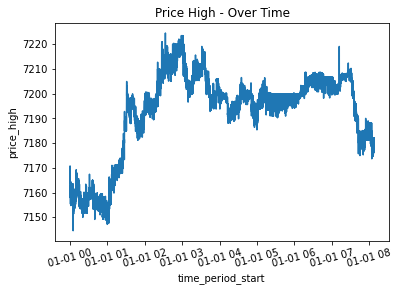

In [5]:
#create plot of time series data - Price High
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x="time_period_start", y="price_high", data=data)
plt.xticks(rotation=15)
plt.title('Price High - Over Time')
plt.show()

## <span style='color:Red'> Problem: spike over a few days, then flat price for several days, then a dip  </span>

#### High variance - might be difficult for a model to predict price with this type of spike, flat, spike downward.
    Model will need to be able to account for large changes in price over short periods of time
    Can be done with NN - might require longer learning time (ephocs)
    XGBoost Model might be better in this case, as it will split based on the spikes

### Review histogram to validate understanding of target variable price_high

In [6]:
data.shape

(10000, 7)

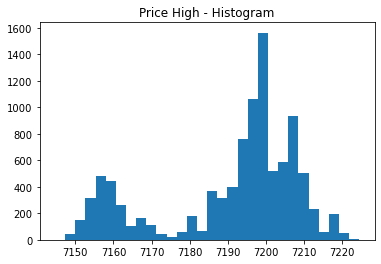

In [8]:
#create histogram of price_high
price_high = data.loc[:,['price_high']]
plt.hist(price_high, 30)
plt.title('Price High - Histogram')
plt.show()

##### There are two or three distinct groupings of the data.  

In [9]:
#change time_period_start to date & create row number to check rolling avg below
data['time_period_start']= pd.to_datetime(data['time_period_start'])
data['row_num'] = np.arange(len(data))  #created to check any future calculations
data.head() #Always check the data after a drop/change

,time_period_start,price_open,price_high,price_low,price_close,volume_traded,trades_count,row_num
0,2020-01-01 00:00:00+00:00,7165.72,7165.72,7165.71,7165.71,0.021841,2,0
1,2020-01-01 00:00:01+00:00,7168.30,7168.30,7168.30,7168.30,1.000000,2,1
2,2020-01-01 00:00:02+00:00,7170.50,7170.50,7170.50,7170.50,0.002000,1,2
3,2020-01-01 00:00:04+00:00,7169.20,7169.20,7169.20,7169.20,0.004000,2,3
4,2020-01-01 00:00:05+00:00,7169.20,7169.20,7169.20,7169.20,0.002000,1,4


## Add New Feature 
    Measure mean between prior three days - add difference as a feature
    Basically, a rolling average of the prior three days
    This smooths the data
    This might be the best option as a target variable as it will vary less from point to point in time
    Will leave it as a feature to the model, might want to explore as a target
    Exercise was not to create a new target

In [10]:
pd.set_option('display.max_rows', None)
data['price_rollmean'] = data['price_high'].rolling(window=4,center=False).mean()
data['price_rollmean'].iloc[0] = data['price_high'].iloc[0]
#drop the first three records
data_t1 = data[3:]  #drop initial 3 rows as they are NA for the average
data_t1.head(1000) #review large amount of data to check calculations, verify 1st row

/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,time_period_start,price_open,price_high,price_low,price_close,volume_traded,trades_count,row_num,price_rollmean
3,2020-01-01 00:00:04+00:00,7169.20,7169.20,7169.20,7169.20,0.004000,2,3,7168.4300
4,2020-01-01 00:00:05+00:00,7169.20,7169.20,7169.20,7169.20,0.002000,1,4,7169.3000
5,2020-01-01 00:00:06+00:00,7165.72,7169.20,7165.72,7169.20,0.075433,3,5,7169.5250
6,2020-01-01 00:00:08+00:00,7165.72,7165.72,7165.72,7165.72,0.017024,2,6,7168.3300
7,2020-01-01 00:00:09+00:00,7165.72,7165.72,7165.72,7165.72,0.040059,1,7,7167.4600
8,2020-01-01 00:00:10+00:00,7165.72,7165.72,7165.72,7165.72,0.006667,1,8,7166.5900
9,2020-01-01 00:00:11+00:00,7165.72,7165.72,7165.72,7165.72,0.002777,1,9,7165.7200
10,2020-01-01 00:00:12+00:00,7165.72,7165.72,7164.90,7164.90,0.074787,2,10,7165.7200
11,2020-01-01 00:00:14+00:00,7163.80,7163.80,7163.80,7163.80,0.300000,1,11,7165.2400
12,2020-01-01 00:00:15+00:00,7165.72,7165.72,7165.72,7165.72,0.200297,3,12,7165.2400


In [11]:
#check tail of data to verify new feature calc did not impact data
data_t1.tail()

,time_period_start,price_open,price_high,price_low,price_close,volume_traded,trades_count,row_num,price_rollmean
9995,2020-01-01 08:07:45+00:00,7179.50,7179.50,7179.50,7179.50,0.013325,1,9995,7179.7050
9996,2020-01-01 08:07:53+00:00,7181.67,7181.67,7181.67,7181.67,0.013364,1,9996,7179.9275
9997,2020-01-01 08:07:57+00:00,7179.50,7179.50,7179.50,7179.50,0.001526,1,9997,7179.9275
9998,2020-01-01 08:07:58+00:00,7182.12,7182.12,7182.12,7182.12,0.013437,1,9998,7180.6975
9999,2020-01-01 08:08:00+00:00,7176.56,7176.56,7176.56,7176.56,0.000010,1,9999,7179.9625


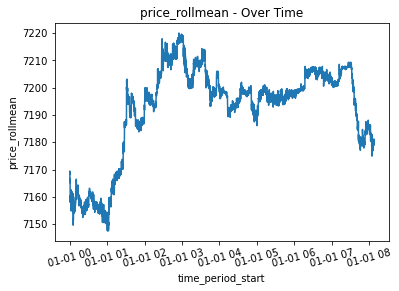

In [12]:
#review the plot of the new feature
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x="time_period_start", y="price_rollmean", data=data_t1)
plt.xticks(rotation=15)
plt.title('price_rollmean - Over Time')
plt.show()

#### Data is much smoother, might be better to build the model based on the rolling mean for 3 seconds

In [13]:
#drop time_period_start now that lineplots based on time are no longer needed
data_t1 = data_t1.drop('time_period_start', 1)

4.911242940708716
335.2510922940258


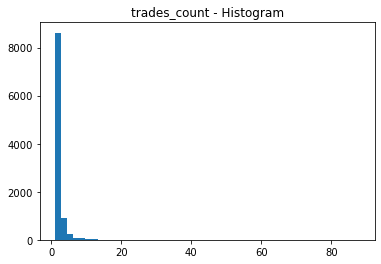

In [14]:
#Based on visual review of the data trades_count appears not to have too many values
#compute variance compared to target
print(data_t1.var()['trades_count'])
print(data_t1.var()['price_high'])
#Variance is very low for trades_count, look at distribution, attibute might be not usefull at all to the model
price_open = data_t1.loc[:,['trades_count']]
plt.hist(price_open, 50)
plt.title('trades_count - Histogram')
plt.show()

#### High likely to delete this attribute due to low variance compared to variance of target
    However wait until check corr

3.2798106809804057
335.2510922940258


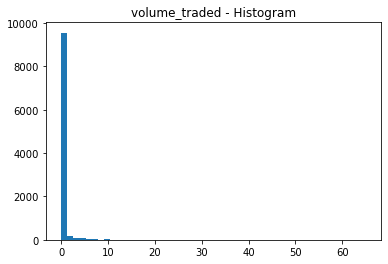

In [15]:
#Same issue for volume traded, variance low, distribution low, not useful to model
#compute variance compared to target
print(data_t1.var()['volume_traded'])
print(data_t1.var()['price_high'])
#Variance is very low for trades_count, look at distribution, attibute might be not usefull at all to the model
price_open = data_t1.loc[:,['volume_traded']]
plt.hist(price_open, 50)
plt.title('volume_traded - Histogram')
plt.show()

#### High likely to delete due to low variance compared to variance of target
    However wait until check corr

### Might not be neccessary to have price_high price_low and price_close in the model if they are providing the same information
### Check correlations

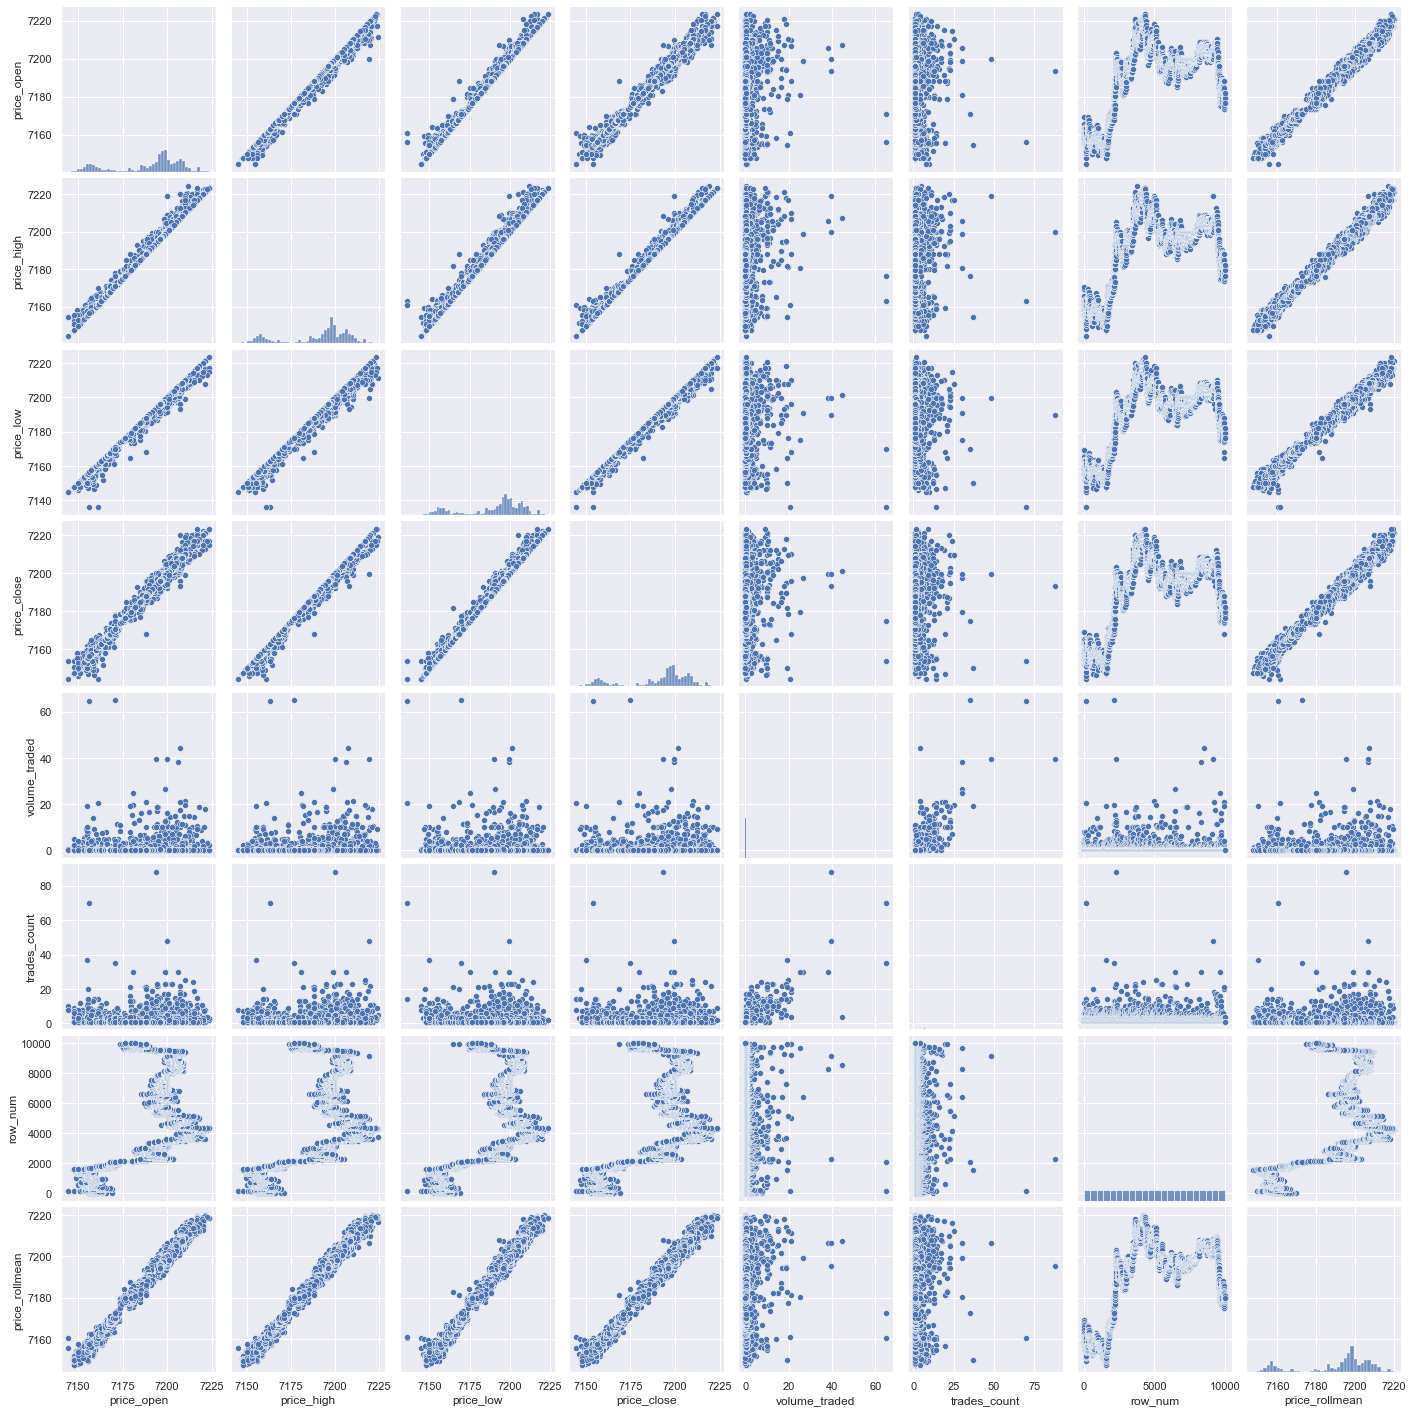

In [16]:
import seaborn as sns
sns.set()  #replaces standard mathplot to seaborn

sns.pairplot(data_t1, height=2.5)

#### many of the attributes are providing the same information and some have no correlation to high_price
#### check correlation_df

In [18]:
correlation_df = data_t1.corr()
print(correlation_df)

                price_open  price_high  price_low  price_close  volume_traded  \
price_open        1.000000    0.998607   0.998469     0.997647      -0.004377   
price_high        0.998607    1.000000   0.997006     0.998475       0.008904   
price_low         0.998469    0.997006   1.000000     0.998629      -0.024946   
price_close       0.997647    0.998475   0.998629     1.000000      -0.010545   
volume_traded    -0.004377    0.008904  -0.024946    -0.010545       1.000000   
trades_count     -0.024131   -0.003730  -0.047363    -0.027342       0.744677   
row_num           0.631003    0.628503   0.631408     0.629278      -0.030319   
price_rollmean    0.996459    0.996411   0.995716     0.995983      -0.001380   

                trades_count   row_num  price_rollmean  
price_open         -0.024131  0.631003        0.996459  
price_high         -0.003730  0.628503        0.996411  
price_low          -0.047363  0.631408        0.995716  
price_close        -0.027342  0.629278    

#### Remove variables below due to high correlation to each other and providing same information to target
    trades_count - low corr, low var
    volume_traded - low corr, lar var
    price_low - lowest corr to price_high, high_corr to other attributes
    price_close - lower corr than price_open, high corr to other attributes
    row_num - not needed, just used to check rollowing mean
    NOTE - keep price_rollmean - smooths every second flux

## This is a lookback model, can remove attributes with high corr to each other

In [185]:
#Drops
data_t2 = data_t1.drop(['trades_count','volume_traded','price_low','price_close', 'row_num'], 1)
data_t2.head() #always check data

,price_open,price_high,price_rollmean
3,7169.20,7169.20,7168.430
4,7169.20,7169.20,7169.300
5,7165.72,7169.20,7169.525
6,7165.72,7165.72,7168.330
7,7165.72,7165.72,7167.460


## Even if these values are similar, the data should be normalized for NN as a best practice.

In [186]:
#Normalize data around the mean
column_maxes = data_t2.max()
df_max = column_maxes.max()
column_mins = data_t2.min()
df_min = column_mins.min()
normalized_df = (data_t2 - df_min) / (df_max - df_min)
normalized_df.head()

,price_open,price_high,price_rollmean
3,0.307596,0.307596,0.297960
4,0.307596,0.307596,0.308847
5,0.264047,0.307596,0.311663
6,0.264047,0.264047,0.296709
7,0.264047,0.264047,0.285822


## Lookback Window

In order to capture the past as features, we create the below function. It takes as input some number of seconds to look back, defaulted to 60 seconds.

#### Vary look back based on 10, 15, 30, 60, 90, 120 and re-run model to see what works the best 

In [133]:
def lookback(dataset, timesteps):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    normalized_df = dataset
    for i in range(1, timesteps):
        step_back = dataset.shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset.columns if column != 'index']
        normalized_df = normalized_df.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
    
    #drop values related to same time period of target
    normalized_df = normalized_df.drop(['price_open', 'price_rollmean'], 1)
        
    return normalized_df.dropna()

In [134]:
def run_model(NumNodesLayerOne, NumNodesLayerTwo, NumNodesLayerThree, LearningRate, NumEpochs, features, target, modelname):
    model = Sequential()
    model.add(Dense(NumNodesLayerOne, activation='relu', input_dim=features.shape[1]))
    model.add(Dense(NumNodesLayerTwo, activation='relu'))
    model.add(Dense(NumNodesLayerThree, activation='relu'))
    #might not need more than 2 hidden layers, might only need 1 given this is rather standard data
    #but models seemed to perfrom better with 3
    model.add(Dense(1)) #no activation function on last node for numeric target
    
    #create main model step
    model.compile(loss='mse',optimizer=RMSprop(lr=LearningRate), metrics=['mae', 'mse'])
    
    ## callbacks
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True)
    
    history = model.fit(features, target, validation_split=.3, epochs=NumEpochs, verbose=0, callbacks=[PrintDot()])
    
    model.save(modelname)
    
    return history

In [135]:
# Display a dot during training, used when number of ephocs is large or large dataset, will show training is working
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0:
            print('')
        print('.', end='')


In [136]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased
%matplotlib inline
def plot_history(history):
    df_hist = pd.DataFrame(history.history)
    df_hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error - Price_High')
    plt.plot(df_hist['epoch'], df_hist['mae'], label='Mean Absolute Error of Train Data')
    plt.plot(df_hist['epoch'], df_hist['val_mae'], label='Mean Absolute Error of Test Data')
    plt.legend()
    plt.title("10 Prior Seconds")
    plt.ylim([0,0.2])
    
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error - Price_High')
    plt.plot(df_hist['epoch'], df_hist['mse'], label='Mean Square Error of Train Data')
    plt.plot(df_hist['epoch'], df_hist['val_mse'], label='Mean Square Error of Test Data')
    plt.legend()
    plt.title("10 Prior Seconds")
    plt.ylim([0,0.02])

#### Model run will allow to differ the number of time periods and model attributes to test different versions

In [31]:
features = lookback(normalized_df, 10)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/10_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(20, 10, 5, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/10_TimePeriods')

print(model.summary())

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)

/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/10_TimePeriods/assets
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                560       
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
 dense_6 (Dense)             (None, 5)                 55        
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 831
Trainable params: 831
Non-trainable p

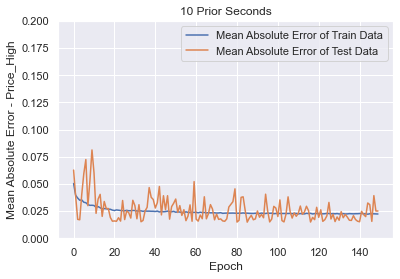

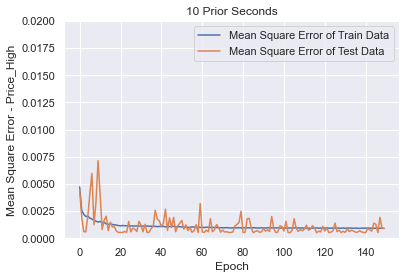

In [32]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [33]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.000934,0.022573,0.000934,0.001290,0.030952,0.001290
146,0.000930,0.022599,0.000930,0.000524,0.015573,0.000524
147,0.000926,0.022510,0.000926,0.001925,0.039244,0.001925
148,0.000921,0.022376,0.000921,0.000934,0.025097,0.000934
149,0.000918,0.022357,0.000918,0.000897,0.025104,0.000897


In [61]:
features = lookback(normalized_df, 15)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/15_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(30, 15, 7, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/15_TimePeriods')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)


/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/15_TimePeriods/assets
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 30)                1290      
                                                                 
 dense_49 (Dense)            (None, 15)                465       
                                                                 
 dense_50 (Dense)            (None, 7)                 112       
                                                                 
 dense_51 (Dense)            (None, 1)                 8         
                                                                 
Total params: 1,875
Trainable params: 1,875
Non-traina

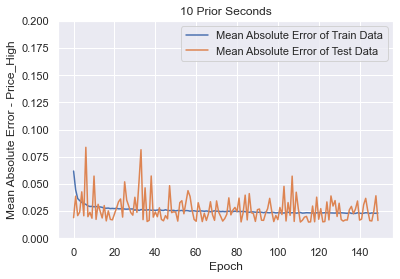

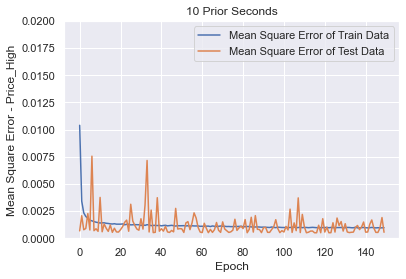

In [62]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [63]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.000957,0.022890,0.000957,0.000545,0.016254,0.000545
146,0.000973,0.023377,0.000973,0.000540,0.015947,0.000540
147,0.000958,0.023001,0.000958,0.000940,0.025314,0.000940
148,0.000966,0.023023,0.000966,0.001909,0.039110,0.001909
149,0.000974,0.023249,0.000974,0.000553,0.016391,0.000553


In [70]:
features = lookback(normalized_df, 20)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/20_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(40, 20, 10, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/20_TimePeriods')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)


/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/20_TimePeriods/assets
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 40)                2320      
                                                                 
 dense_61 (Dense)            (None, 20)                820       
                                                                 
 dense_62 (Dense)            (None, 10)                210       
                                                                 
 dense_63 (Dense)            (None, 1)                 11        
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-traina

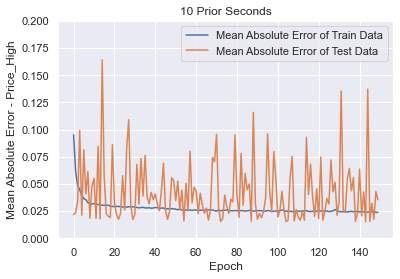

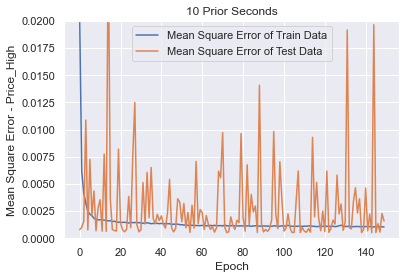

In [71]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [72]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.001100,0.024392,0.001100,0.000526,0.015521,0.000526
146,0.001060,0.024451,0.001060,0.001349,0.032267,0.001349
147,0.001083,0.024621,0.001083,0.000571,0.017486,0.000571
148,0.001055,0.023793,0.001055,0.002278,0.043078,0.002278
149,0.001049,0.023984,0.001049,0.001582,0.035353,0.001582


In [67]:
features = lookback(normalized_df, 30)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/30_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(60, 30, 15, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/30_TimePeriods')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)


/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/30_TimePeriods/assets
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 60)                5280      
                                                                 
 dense_57 (Dense)            (None, 30)                1830      
                                                                 
 dense_58 (Dense)            (None, 15)                465       
                                                                 
 dense_59 (Dense)            (None, 1)                 16        
                                                                 
Total params: 7,591
Trainable params: 7,591
Non-traina

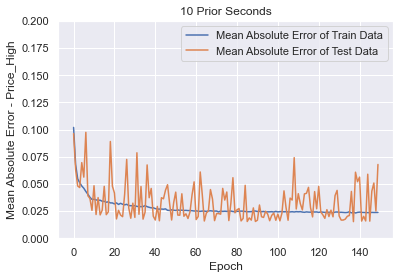

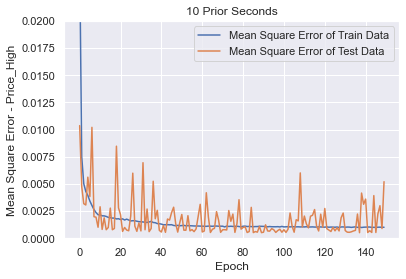

In [68]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [69]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.001003,0.023586,0.001003,0.000533,0.015774,0.000533
146,0.001019,0.023849,0.001019,0.002256,0.043384,0.002256
147,0.001024,0.023768,0.001024,0.003000,0.050849,0.003000
148,0.001010,0.023829,0.001010,0.000898,0.025088,0.000898
149,0.001017,0.023800,0.001017,0.005209,0.067909,0.005209


In [43]:
features = lookback(normalized_df, 45)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/45_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(90, 45, 20, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/45_TimePeriods')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)


/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/45_TimePeriods/assets
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 90)                11970     
                                                                 
 dense_21 (Dense)            (None, 45)                4095      
                                                                 
 dense_22 (Dense)            (None, 20)                920       
                                                                 
 dense_23 (Dense)            (None, 1)                 21        
                                                                 
Total params: 17,006
Trainable params: 17,006
Non-train

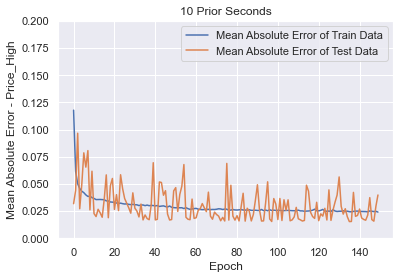

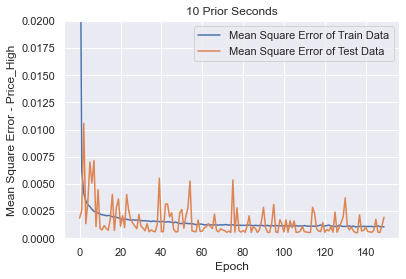

In [44]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [45]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.001104,0.025173,0.001104,0.001744,0.037403,0.001744
146,0.001146,0.024899,0.001146,0.000575,0.017199,0.000575
147,0.001068,0.024599,0.001068,0.000530,0.015753,0.000530
148,0.001072,0.024817,0.001072,0.001167,0.029472,0.001167
149,0.001061,0.024127,0.001061,0.001945,0.039842,0.001945


In [46]:
features = lookback(normalized_df, 60)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/60_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(120, 60, 25, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/60_TimePeriods')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)


/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/60_TimePeriods/assets
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 120)               21360     
                                                                 
 dense_25 (Dense)            (None, 60)                7260      
                                                                 
 dense_26 (Dense)            (None, 25)                1525      
                                                                 
 dense_27 (Dense)            (None, 1)                 26        
                                                                 
Total params: 30,171
Trainable params: 30,171
Non-train

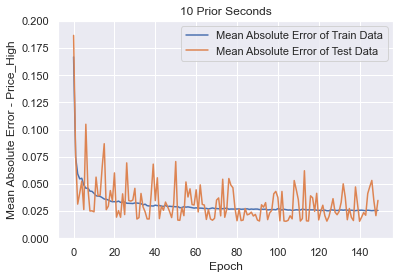

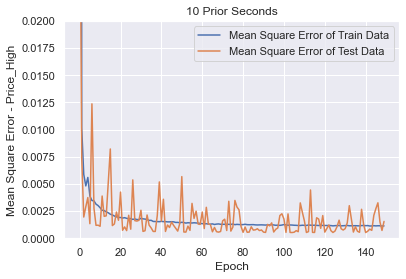

In [47]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [48]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.001141,0.025636,0.001141,0.002726,0.047494,0.002726
146,0.001155,0.025416,0.001155,0.003264,0.053230,0.003264
147,0.001151,0.025595,0.001151,0.001515,0.034487,0.001515
148,0.001125,0.025606,0.001125,0.000725,0.020834,0.000725
149,0.001140,0.025644,0.001140,0.001552,0.034874,0.001552


In [60]:
features = lookback(normalized_df, 90)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/90_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(270, 135, 67, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/90_TimePeriods')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)


/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/90_TimePeriods/assets
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 270)               72360     
                                                                 
 dense_45 (Dense)            (None, 135)               36585     
                                                                 
 dense_46 (Dense)            (None, 67)                9112      
                                                                 
 dense_47 (Dense)            (None, 1)                 68        
                                                                 
Total params: 118,125
Trainable params: 118,125
Non-tr

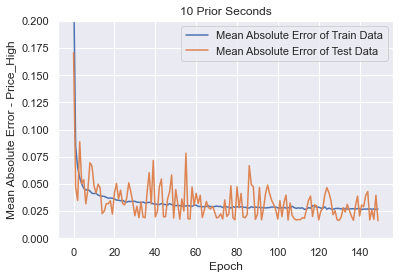

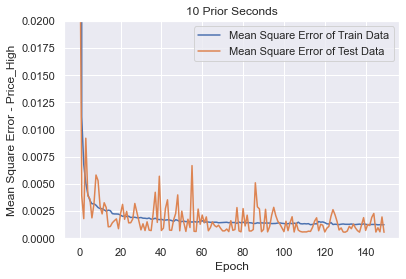

In [50]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [51]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.001275,0.027068,0.001275,0.000577,0.016933,0.000577
146,0.001241,0.026669,0.001241,0.000971,0.026083,0.000971
147,0.001252,0.027059,0.001252,0.000595,0.017373,0.000595
148,0.001247,0.026610,0.001247,0.001964,0.039533,0.001964
149,0.001248,0.027011,0.001248,0.000548,0.016176,0.000548


In [144]:
features = lookback(normalized_df, 120)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/120_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(360, 180, 90, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/120_TimePeriods')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)

/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/120_TimePeriods/assets
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 360)               129240    
                                                                 
 dense_73 (Dense)            (None, 180)               64980     
                                                                 
 dense_74 (Dense)            (None, 90)                16290     
                                                                 
 dense_75 (Dense)            (None, 1)                 91        
                                                                 
Total params: 210,601
Trainable params: 210,601
Non-t

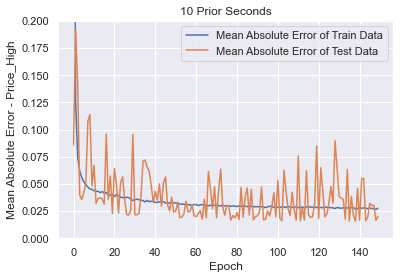

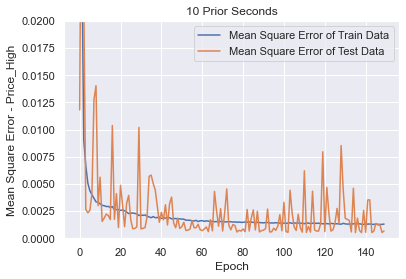

In [145]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [146]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.001305,0.027789,0.001305,0.001369,0.032195,0.001369
146,0.001285,0.027534,0.001285,0.001218,0.030100,0.001218
147,0.001276,0.027181,0.001276,0.001244,0.030333,0.001244
148,0.001279,0.026699,0.001279,0.000540,0.016431,0.000540
149,0.001309,0.027731,0.001309,0.000671,0.019981,0.000671


In [55]:
features = lookback(normalized_df, 300) #try the prior five minutes
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/300_TimePeriods'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(700, 350, 150, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/300_TimePeriods')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)

/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/300_TimePeriods/assets
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 700)               628600    
                                                                 
 dense_37 (Dense)            (None, 350)               245350    
                                                                 
 dense_38 (Dense)            (None, 150)               52650     
                                                                 
 dense_39 (Dense)            (None, 1)                 151       
                                                                 
Total params: 926,751
Trainable params: 926,751
Non-tr

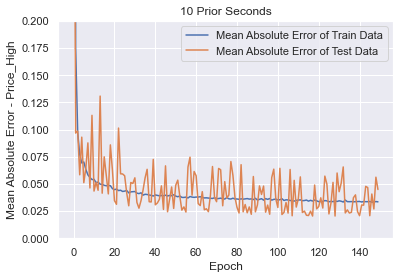

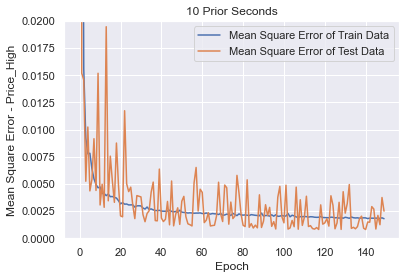

In [56]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [57]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.001858,0.033829,0.001858,0.000854,0.020786,0.000854
146,0.001848,0.033309,0.001848,0.002107,0.040731,0.002107
147,0.001830,0.033379,0.001830,0.001248,0.026999,0.001248
148,0.001885,0.033805,0.001885,0.003752,0.056209,0.003752
149,0.001803,0.033532,0.001803,0.002499,0.044882,0.002499


# Done testing different version -- load final model and make predictions

## Best model was looking back 15 seconds

In [77]:
#create 15 second features
features = lookback(normalized_df, 15)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values

#load 15 second model
model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/15_TimePeriods')

#make predictions
predictions = model.predict(features)

In [78]:
#de-normalize the data 
denormalized_ds = (predictions * (df_max - df_min)) + df_min

#convert to pandas dataframe
pred_data = pd.DataFrame(denormalized_ds, columns = ['Pred_Price_High'])
pred_data.head()

,Pred_Price_High
0,7159.370117
1,7157.802734
2,7160.239258
3,7159.567871
4,7158.081055


## Now need to compare de-normalized predictions to actual predictions

In [79]:
#de-normalize orginal target data
denormalized_target = (target * (df_max - df_min)) + df_min

#convert to pandas dataframe
orginal_data = pd.DataFrame(denormalized_target, columns = ['Orginal_Price_High'])

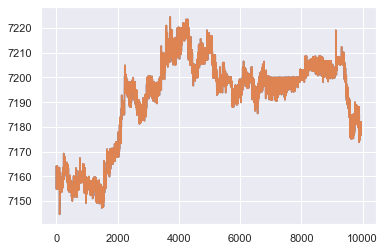

In [80]:
plt.plot(orginal_data, label='Original Data')
plt.plot(denormalized_target, label="Predicted Data")
plt.show()

### Calculate MSE and RMSE on de-normalized data

In [81]:
mse = mean_squared_error(orginal_data, pred_data)
print("MSE: %0.2f" % (mse))

MSE: 4.20


In [82]:
rmse = np.sqrt(mse)
print("RMSE: %0.2f" % (rmse))

RMSE: 2.05


# A hold-out Validation dataset should have been created to test the final model

# Test an XGBoost Model with 60 - second look-back

In [83]:
#use non-normalized data
features = lookback(data_t2, 90)
target = features['price_high'].values
x_features = features.drop('price_high', axis=1).values
target_train, target_test, features_train, features_test = train_test_split(target, x_features, test_size = 0.3, random_state=1967)


In [84]:
features.head()

,price_high,price_open_-1,price_high_-1,price_rollmean_-1,price_open_-2,price_high_-2,price_rollmean_-2,price_open_-3,price_high_-3,price_rollmean_-3,...,price_rollmean_-86,price_open_-87,price_high_-87,price_rollmean_-87,price_open_-88,price_high_-88,price_rollmean_-88,price_open_-89,price_high_-89,price_rollmean_-89
89,7165.52,7162.22,7162.22,7162.075,7162.22,7162.22,7161.690,7162.22,7162.22,7162.385,...,7166.8325,7163.80,7163.80,7165.2400,7165.72,7165.72,7167.46,7169.20,7169.20,7168.430
90,7162.22,7163.00,7165.52,7163.045,7161.64,7161.64,7161.810,7161.16,7161.16,7161.955,...,7166.1500,7165.72,7165.72,7165.2400,7165.72,7165.72,7166.59,7169.20,7169.20,7169.300
91,7162.22,7162.22,7162.22,7163.045,7162.22,7162.22,7162.075,7161.16,7161.16,7161.690,...,7164.2775,7165.72,7170.79,7166.5075,7165.72,7165.72,7165.72,7165.72,7169.20,7169.525
92,7162.22,7162.22,7162.22,7163.045,7162.22,7162.22,7162.075,7162.22,7162.22,7161.690,...,7162.9125,7165.10,7165.10,7166.3525,7165.72,7165.72,7165.72,7165.72,7165.72,7168.330
93,7162.22,7162.22,7162.22,7163.045,7162.22,7162.22,7162.075,7162.22,7162.22,7161.690,...,7161.3900,7165.72,7165.72,7166.8325,7163.80,7163.80,7165.24,7165.72,7165.72,7167.460


In [85]:
target_train.view()

array([7147.69, 7199.95, 7219.3 , ..., 7202.52, 7207.79, 7186.01])

In [86]:
features_train.view()

array([[7147.69  , 7147.69  , 7151.695 , ..., 7154.82  , 7154.82  ,
        7155.5075],
       [7199.95  , 7199.95  , 7197.34  , ..., 7196.43  , 7199.    ,
        7198.9475],
       [7220.06  , 7220.06  , 7217.765 , ..., 7215.    , 7215.    ,
        7213.445 ],
       ...,
       [7206.85  , 7206.85  , 7206.925 , ..., 7198.99  , 7198.99  ,
        7199.245 ],
       [7207.65  , 7207.65  , 7207.72  , ..., 7200.02  , 7200.02  ,
        7200.7825],
       [7181.16  , 7187.32  , 7185.125 , ..., 7193.85  , 7193.85  ,
        7194.1725]])

In [87]:
#test train vs. train stats
np.mean(target_train)

7192.149613333333

In [88]:
#test train vs. train
np.mean(target_test)

7191.894298548722

In [89]:
#create xgboost matrices
Train = xgb.DMatrix(features_train, label = target_train)
Test = xgb.DMatrix(features_test, label = target_test)

In [90]:
#run xgboost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
xgb_model.fit(features_train, target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [91]:
test_xgb = xgb_model.predict(features_test)
test_xgb

array([7186.4844, 7198.3594, 7152.1514, ..., 7205.1494, 7202.906 ,
       7208.712 ], dtype=float32)

In [92]:
xgb_model.score(features_train, target_train) * 100

99.73449112964957

In [93]:
xgb_model.score(features_test, target_test) * 100

98.56277144750064

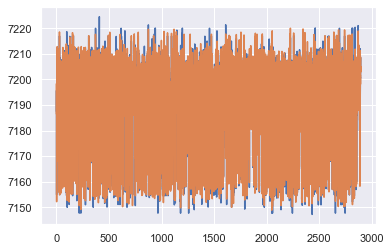

In [94]:
plt.plot(target_test, label='Original Data')
plt.plot(test_xgb, label="Predicted Data")
plt.show()

In [95]:
mse = mean_squared_error(target_test, test_xgb)
print("MSE: %0.2f" % (mse))

MSE: 4.44


In [96]:
rmse = np.sqrt(mse)
print("RMSE: %0.2f" % (rmse))

RMSE: 2.11


## Test XGBoost on different time period - same as best NN model - 15 seconds

In [97]:
#use non-normalized data
features = lookback(data_t2, 15)
target = features['price_high'].values
x_features = features.drop('price_high', axis=1).values
target_train, target_test, features_train, features_test = train_test_split(target, x_features, test_size = 0.3, random_state=1967)


In [98]:
features.head()

,price_high,price_open_-1,price_high_-1,price_rollmean_-1,price_open_-2,price_high_-2,price_rollmean_-2,price_open_-3,price_high_-3,price_rollmean_-3,...,price_rollmean_-11,price_open_-12,price_high_-12,price_rollmean_-12,price_open_-13,price_high_-13,price_rollmean_-13,price_open_-14,price_high_-14,price_rollmean_-14
14,7154.82,7161.20,7161.20,7159.4925,7158.65,7158.65,7157.8275,7159.82,7159.82,7160.4200,...,7166.8325,7163.80,7163.80,7165.2400,7165.72,7165.72,7167.46,7169.20,7169.20,7168.430
15,7164.23,7154.82,7154.82,7158.0900,7160.43,7160.43,7157.9825,7159.81,7159.81,7159.9950,...,7166.1500,7165.72,7165.72,7165.2400,7165.72,7165.72,7166.59,7169.20,7169.20,7169.300
16,7163.30,7164.23,7164.23,7159.0400,7160.43,7160.43,7158.9775,7156.45,7156.45,7159.0000,...,7164.2775,7165.72,7170.79,7166.5075,7165.72,7165.72,7165.72,7165.72,7169.20,7169.525
17,7154.97,7163.30,7163.30,7160.8875,7155.91,7155.91,7158.8550,7156.40,7156.40,7158.1200,...,7162.9125,7165.10,7165.10,7166.3525,7165.72,7165.72,7165.72,7165.72,7165.72,7168.330
18,7163.40,7154.97,7154.97,7159.3300,7161.20,7161.20,7159.4925,7158.65,7158.65,7157.8275,...,7161.3900,7165.72,7165.72,7166.8325,7163.80,7163.80,7165.24,7165.72,7165.72,7167.460


In [99]:
target_train.view()

array([7193.98, 7199.  , 7197.37, ..., 7199.28, 7200.01, 7190.99])

In [100]:
features_train.view()

array([[7193.98  , 7199.95  , 7195.4725, ..., 7193.52  , 7193.52  ,
        7196.985 ],
       [7199.    , 7199.    , 7199.    , ..., 7198.    , 7198.    ,
        7197.9825],
       [7197.37  , 7197.37  , 7197.37  , ..., 7197.37  , 7197.37  ,
        7198.015 ],
       ...,
       [7199.99  , 7199.99  , 7200.7625, ..., 7198.99  , 7198.99  ,
        7199.245 ],
       [7200.01  , 7200.01  , 7200.01  , ..., 7200.02  , 7200.02  ,
        7200.7825],
       [7190.77  , 7190.77  , 7192.72  , ..., 7193.85  , 7193.85  ,
        7194.1725]])

In [101]:
#test train vs. train stats
np.mean(target_train)

7191.00070545977

In [102]:
#test train vs. train
np.mean(target_test)

7191.186759383378

In [103]:
#create xgboost matrices
Train = xgb.DMatrix(features_train, label = target_train)
Test = xgb.DMatrix(features_test, label = target_test)

In [104]:
#run xgboost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
xgb_model.fit(features_train, target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [105]:
test_xgb = xgb_model.predict(features_test)
test_xgb

array([7197.6904, 7209.353 , 7209.035 , ..., 7204.878 , 7159.0625,
       7207.374 ], dtype=float32)

In [106]:
xgb_model.score(features_train, target_train) * 100

99.6699618590647

In [107]:
xgb_model.score(features_test, target_test) * 100

98.72082224100734

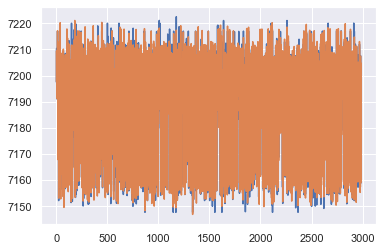

In [108]:
plt.plot(target_test, label='Original Data')
plt.plot(test_xgb, label="Predicted Data")
plt.show()

In [109]:
mse = mean_squared_error(target_test, test_xgb)
print("MSE: %0.2f" % (mse))

MSE: 4.25


In [110]:
rmse = np.sqrt(mse)
print("RMSE: %0.2f" % (rmse))

RMSE: 2.06


## Test XGBoost on very long time period - 120 seconds

In [111]:
#use non-normalized data
features = lookback(data_t2, 15)
target = features['price_high'].values
x_features = features.drop('price_high', axis=1).values
target_train, target_test, features_train, features_test = train_test_split(target, x_features, test_size = 0.3, random_state=1967)


In [112]:
features.head()

,price_high,price_open_-1,price_high_-1,price_rollmean_-1,price_open_-2,price_high_-2,price_rollmean_-2,price_open_-3,price_high_-3,price_rollmean_-3,...,price_rollmean_-11,price_open_-12,price_high_-12,price_rollmean_-12,price_open_-13,price_high_-13,price_rollmean_-13,price_open_-14,price_high_-14,price_rollmean_-14
14,7154.82,7161.20,7161.20,7159.4925,7158.65,7158.65,7157.8275,7159.82,7159.82,7160.4200,...,7166.8325,7163.80,7163.80,7165.2400,7165.72,7165.72,7167.46,7169.20,7169.20,7168.430
15,7164.23,7154.82,7154.82,7158.0900,7160.43,7160.43,7157.9825,7159.81,7159.81,7159.9950,...,7166.1500,7165.72,7165.72,7165.2400,7165.72,7165.72,7166.59,7169.20,7169.20,7169.300
16,7163.30,7164.23,7164.23,7159.0400,7160.43,7160.43,7158.9775,7156.45,7156.45,7159.0000,...,7164.2775,7165.72,7170.79,7166.5075,7165.72,7165.72,7165.72,7165.72,7169.20,7169.525
17,7154.97,7163.30,7163.30,7160.8875,7155.91,7155.91,7158.8550,7156.40,7156.40,7158.1200,...,7162.9125,7165.10,7165.10,7166.3525,7165.72,7165.72,7165.72,7165.72,7165.72,7168.330
18,7163.40,7154.97,7154.97,7159.3300,7161.20,7161.20,7159.4925,7158.65,7158.65,7157.8275,...,7161.3900,7165.72,7165.72,7166.8325,7163.80,7163.80,7165.24,7165.72,7165.72,7167.460


In [113]:
target_train.view()

array([7193.98, 7199.  , 7197.37, ..., 7199.28, 7200.01, 7190.99])

In [114]:
features_train.view()

array([[7193.98  , 7199.95  , 7195.4725, ..., 7193.52  , 7193.52  ,
        7196.985 ],
       [7199.    , 7199.    , 7199.    , ..., 7198.    , 7198.    ,
        7197.9825],
       [7197.37  , 7197.37  , 7197.37  , ..., 7197.37  , 7197.37  ,
        7198.015 ],
       ...,
       [7199.99  , 7199.99  , 7200.7625, ..., 7198.99  , 7198.99  ,
        7199.245 ],
       [7200.01  , 7200.01  , 7200.01  , ..., 7200.02  , 7200.02  ,
        7200.7825],
       [7190.77  , 7190.77  , 7192.72  , ..., 7193.85  , 7193.85  ,
        7194.1725]])

In [115]:
#test train vs. train stats
np.mean(target_train)

7191.00070545977

In [116]:
#test train vs. train
np.mean(target_test)

7191.186759383378

In [117]:
#create xgboost matrices
Train = xgb.DMatrix(features_train, label = target_train)
Test = xgb.DMatrix(features_test, label = target_test)

In [118]:
#run xgboost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
xgb_model.fit(features_train, target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [119]:
test_xgb = xgb_model.predict(features_test)
test_xgb

array([7197.6904, 7209.353 , 7209.035 , ..., 7204.878 , 7159.0625,
       7207.374 ], dtype=float32)

In [120]:
xgb_model.score(features_train, target_train) * 100

99.6699618590647

In [121]:
xgb_model.score(features_test, target_test) * 100

98.72082224100734

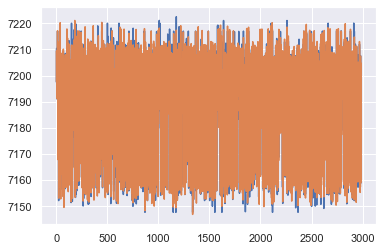

In [122]:
plt.plot(target_test, label='Original Data')
plt.plot(test_xgb, label="Predicted Data")
plt.show()

In [123]:
mse = mean_squared_error(target_test, test_xgb)
print("MSE: %0.2f" % (mse))

MSE: 4.25


In [124]:
rmse = np.sqrt(mse)
print("RMSE: %0.2f" % (rmse))

RMSE: 2.06


# Basic XGBooost performs about the same as a Neural Network

### XGBoost Shorter time period was slightly better

# With NN - number of time slices (seconds) did make a difference with training

## Best NN model was with 15 second look back

# Number of time slices did not appear to make much difference with XGBoost

# Test model without the rolling prior time and price_open period data

### Validate with just price_high as the primary time series attribute

In [175]:
#Drops
data_t3 = data_t1.drop(['trades_count','volume_traded','price_low','price_close', 'row_num', 'price_open', 'price_rollmean'], 1)
data_t3.head() #always check data

,price_high
3,7169.20
4,7169.20
5,7169.20
6,7165.72
7,7165.72


### Normalize data around the mean

In [176]:
column_maxes = data_t3.max()
df_max = column_maxes.max()
column_mins = data_t3.min()
df_min = column_mins.min()
normalized_df_2 = (data_t3 - df_min) / (df_max - df_min)
normalized_df_2.head()

,price_high
3,0.307596
4,0.307596
5,0.307596
6,0.264047
7,0.264047


In [177]:
def lookback(dataset, timesteps):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    normalized_df_2 = dataset
    for i in range(1, timesteps):
        step_back = dataset.shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset.columns if column != 'index']
        normalized_df_2 = normalized_df_2.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
    
    #drop values related to same time period of target
    #normalized_df = normalized_df_2.drop(['price_open'], 1)
        
    return normalized_df_2.dropna()

In [181]:
features = lookback(normalized_df_2, 15)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/15_TimePeriods_price_high_only'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(360, 180, 90, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/15_TimePeriods_price_high_only')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)

/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/15_TimePeriods_price_high_only/assets
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 360)               5400      
                                                                 
 dense_85 (Dense)            (None, 180)               64980     
                                                                 
 dense_86 (Dense)            (None, 90)                16290     
                                                                 
 dense_87 (Dense)            (None, 1)                 91        
                                                                 
Total params: 86,761
Trainable params:

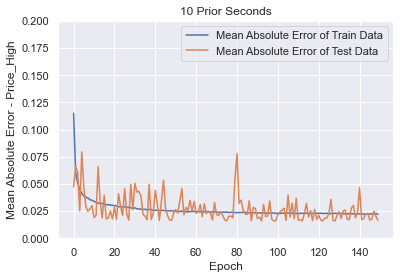

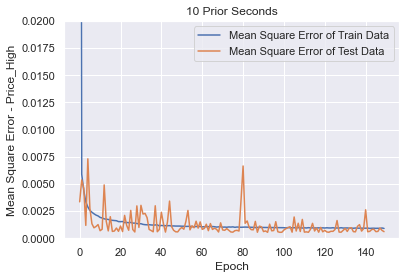

In [182]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [183]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.000916,0.022220,0.000916,0.000612,0.016789,0.000612
146,0.000922,0.022466,0.000922,0.000634,0.017588,0.000634
147,0.000911,0.022157,0.000911,0.000950,0.024894,0.000950
148,0.000948,0.022819,0.000948,0.000731,0.020218,0.000731
149,0.000907,0.022086,0.000907,0.000610,0.016494,0.000610


## Did not make a difference with just price_high

## Run model with rolling average as target just to see what the results are

In [187]:
normalized_df.head()

,price_open,price_high,price_rollmean
3,0.307596,0.307596,0.297960
4,0.307596,0.307596,0.308847
5,0.264047,0.307596,0.311663
6,0.264047,0.264047,0.296709
7,0.264047,0.264047,0.285822


In [189]:
def lookback(dataset, timesteps):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    normalized_df = dataset
    for i in range(1, timesteps):
        step_back = dataset.shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset.columns if column != 'index']
        normalized_df = normalized_df.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
    
    #drop values related to same time period of target
    normalized_df = normalized_df.drop(['price_open', 'price_high'], 1)
        
    return normalized_df.dropna()

In [190]:
features = lookback(normalized_df, 15)
target = features['price_rollmean'].values
features = features.drop('price_rollmean', axis=1).values
modelname = '/Users/jamesmcmillen/downloads/modelsave/15_TimePeriods_rolling_target'

#run model vary the nodes for each layer, learning rate, and number of epochs
history = run_model(360, 180, 90, 0.005, 150, features, target, modelname)

model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/15_TimePeriods_rolling_target')

print(model.summary())

#view last values of metric calcs from model - shows errors
hist = pd.DataFrame(history.history)
hist['ephoc'] = history.epoch
hist.tail()

## prediction
predictions = model.predict(features)
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))
print('Root Mean Sq. Error = ', rmse)

/Users/jamesmcmillen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........INFO:tensorflow:Assets written to: /Users/jamesmcmillen/downloads/modelsave/15_TimePeriods_rolling_target/assets
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 360)               15480     
                                                                 
 dense_89 (Dense)            (None, 180)               64980     
                                                                 
 dense_90 (Dense)            (None, 90)                16290     
                                                                 
 dense_91 (Dense)            (None, 1)                 91        
                                                                 
Total params: 96,841
Trainable params: 

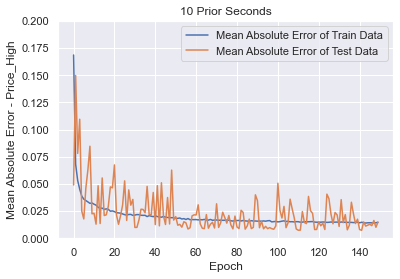

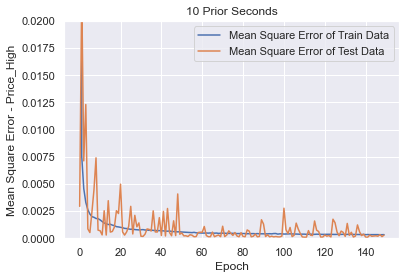

In [192]:
#plot training and testing data based on MAE and MSE to verify model
#look for over-training, and if number of Epochs should be increased 
plot_history(history)
#verify and adjust model for the different number of time periods

In [193]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
145,0.000342,0.014318,0.000342,0.000231,0.012884,0.000231
146,0.000339,0.014184,0.000339,0.000192,0.011627,0.000192
147,0.000327,0.014164,0.000327,0.000343,0.016379,0.000343
148,0.000336,0.014291,0.000336,0.000153,0.010122,0.000153
149,0.000339,0.014719,0.000339,0.000291,0.014853,0.000291


# Using rolling average produced a much better model

# This should be the final model

In [194]:
#create 15 second features
features = lookback(normalized_df, 15)
target = features['price_rollmean'].values
features = features.drop('price_rollmean', axis=1).values

#load 15 second model
model = keras.models.load_model('/Users/jamesmcmillen/downloads/modelsave/15_TimePeriods_rolling_target')

#make predictions
predictions = model.predict(features)

In [195]:
#de-normalize the data 
denormalized_ds = (predictions * (df_max - df_min)) + df_min

#convert to pandas dataframe
pred_data = pd.DataFrame(denormalized_ds, columns = ['Pred_price_rollmean'])
pred_data.head()

,Pred_price_rollmean
0,7159.994141
1,7158.120117
2,7161.092285
3,7161.311035
4,7159.126953


### Calculate MSE and RMSE on de-normalized data

In [196]:
mse = mean_squared_error(orginal_data, pred_data)
print("MSE: %0.2f" % (mse))

MSE: 5.00


In [197]:
rmse = np.sqrt(mse)
print("RMSE: %0.2f" % (rmse))

RMSE: 2.24
